In [1]:
import numpy as np
import pandas as pd
import sys
!{sys.executable} -m pip install pandas_datareader
import pandas_datareader.data as web
import datetime as dt

!{sys.executable} -m pip install pyti
import technical_analysis as ta
import decision_profit as dp
import process_data as proc

import warnings
warnings.filterwarnings('ignore')

You should consider upgrading via the 'C:\Users\rache\OneDrive\Desktop\CFRM\521\code\my_env\Scripts\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\rache\OneDrive\Desktop\CFRM\521\code\my_env\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
start = dt.datetime(2010,1,1)
end = dt.datetime(2021,5,1)
tickers = ['AAPL', 'BAC', 'SPWR']
names = ['Apple', "Bank of America", "SunPower"]
dfs = proc.get_process_df(tickers, start=start, end=end)

In [3]:
X_trains, X_tests, y_trains, y_tests, dfs_train, dfs_test = proc.get_train_test(dfs, original=False)
X_train_subs, X_vals, y_train_subs, y_vals, dfs_train_sub, dfs_val = proc.get_train_val(dfs_train, X_trains, y_trains)

In [4]:
extra_profit_untuned = {}
extra_profit_msetune = {}
extra_profit_protune = {}

## default parameters

In [5]:
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

pipelines = []
models = []
for i in range(len(tickers)):
    models.append(Pipeline([('scaler', StandardScaler()), ('svr', SVR())]))
    
# train and training set summary
dp.train_and_summary(models, names, dfs_train, X_trains, y_trains)

Training set
Apple
number of trading positions taken with actual trend: 79
number of trading positions taken with predicted trend: 207
Bank of America
number of trading positions taken with actual trend: 87
number of trading positions taken with predicted trend: 241
SunPower
number of trading positions taken with actual trend: 93
number of trading positions taken with predicted trend: 330
Training set
Apple
profit with actual trend: 213.06097216798915
profit with predicted trend: 349.26000409629546
Bank of America
profit with actual trend: 115.4669104432161
profit with predicted trend: 296.9836358151948
SunPower
profit with actual trend: 122.95292221909412
profit with predicted trend: 287.4616420857981
average MSE: 0.03197993393125115


In [6]:
# test set summary
dp.test_summary(models, names, 'SVR', dfs_test, X_tests, y_tests, extra_profit_untuned, mse=True)

Test set
Apple
number of trading positions taken with actual trend: 11
number of trading positions taken with predicted trend: 97
Bank of America
number of trading positions taken with actual trend: 24
number of trading positions taken with predicted trend: 80
SunPower
number of trading positions taken with actual trend: 18
number of trading positions taken with predicted trend: 58
Test set
Apple
profit with actual trend: 144.03829362134294
profit with predicted trend: 125.12486673591275
Bank of America
profit with actual trend: 28.419497969871344
profit with predicted trend: 161.49437166638225
SunPower
profit with actual trend: 313.5157616295759
profit with predicted trend: 363.8368172615407
Average MSE SVR 0.2518771937379143


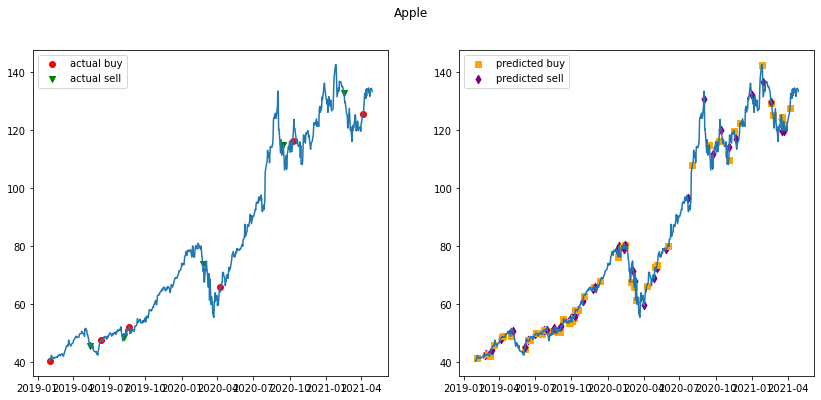

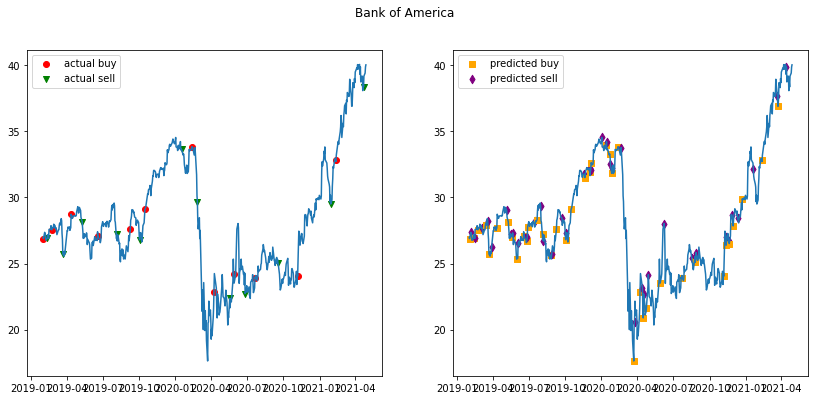

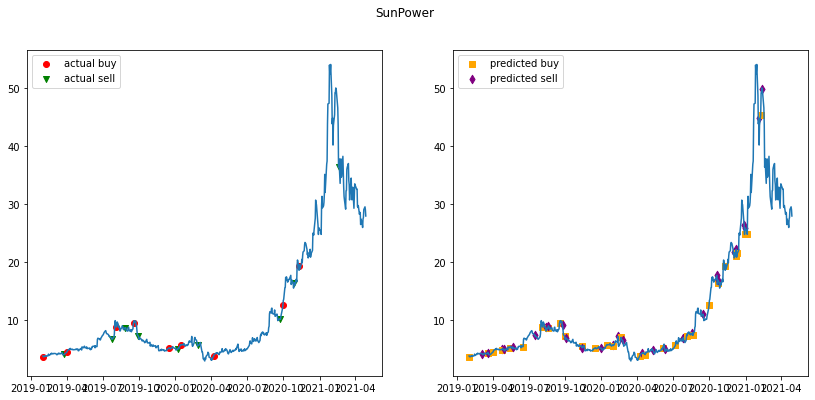

In [7]:
for i in range(len(dfs_test)):
    dp.plot_signals(dfs_test[i], names[i])

## KNN ##

In [8]:
from sklearn.neighbors import KNeighborsRegressor

models = []
for i in range(len(tickers)):
    #models.append(KNeighborsRegressor())
    models.append(Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsRegressor())]))
    
# train and training set summary
dp.train_and_summary(models, names, dfs_train, X_trains, y_trains)

Training set
Apple
number of trading positions taken with actual trend: 79
number of trading positions taken with predicted trend: 251
Bank of America
number of trading positions taken with actual trend: 87
number of trading positions taken with predicted trend: 311
SunPower
number of trading positions taken with actual trend: 93
number of trading positions taken with predicted trend: 444
Training set
Apple
profit with actual trend: 213.06097216798915
profit with predicted trend: 324.5262654217549
Bank of America
profit with actual trend: 115.4669104432161
profit with predicted trend: 260.41356998270135
SunPower
profit with actual trend: 122.95292221909412
profit with predicted trend: 258.45536905591285
average MSE: 0.02361808626051269


In [9]:
# test set summary
dp.test_summary(models, names, 'KNN', dfs_test, X_tests, y_tests, extra_profit_untuned, mse=True)

Test set
Apple
number of trading positions taken with actual trend: 11
number of trading positions taken with predicted trend: 53
Bank of America
number of trading positions taken with actual trend: 24
number of trading positions taken with predicted trend: 78
SunPower
number of trading positions taken with actual trend: 18
number of trading positions taken with predicted trend: 70
Test set
Apple
profit with actual trend: 144.03829362134294
profit with predicted trend: 160.97848292032901
Bank of America
profit with actual trend: 28.419497969871344
profit with predicted trend: 129.60408021767645
SunPower
profit with actual trend: 313.5157616295759
profit with predicted trend: 363.26050467524664
Average MSE KNN 0.23177903347526305


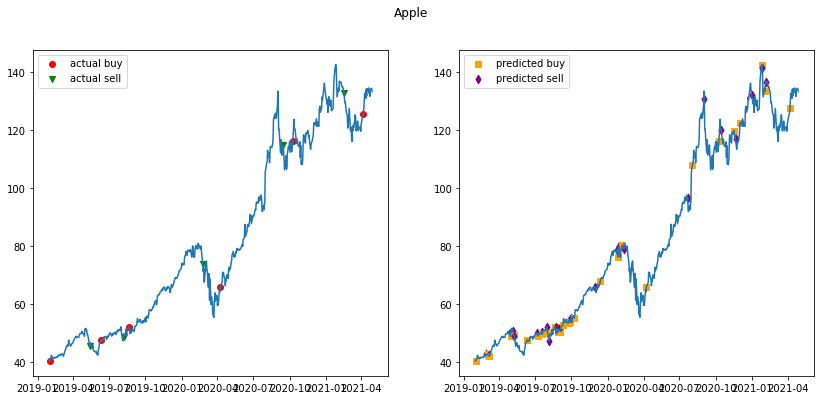

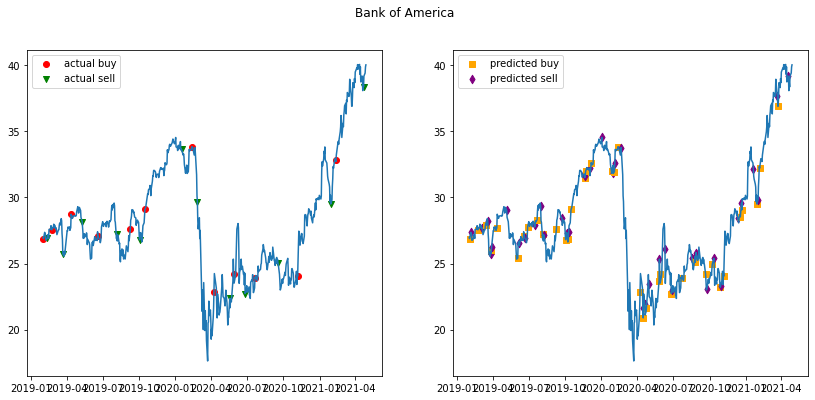

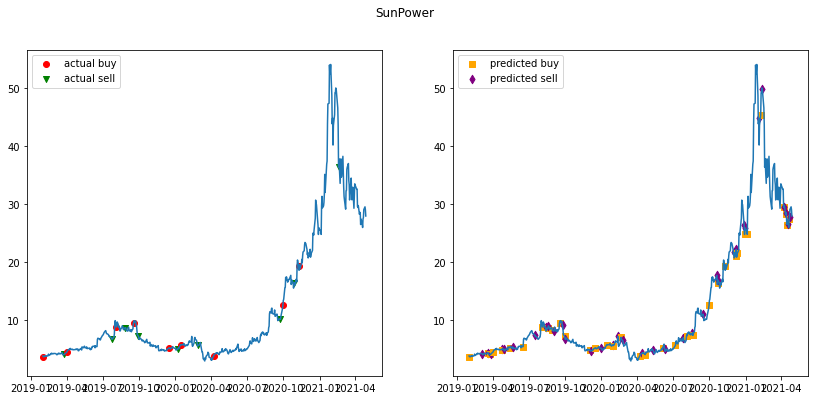

In [10]:
for i in range(len(dfs_test)):
    dp.plot_signals(dfs_test[i], names[i])

In [12]:
extra_profit_untuned

{'SVR': 164.48250244304555, 'KNN': 167.86951459246194}

## parameter tuning with cross validation ##

<h3> using MSE metric (find model that produces smallest mse)
    
<h3> SVR (adding polynomial degrees and pick the best gamma and kernel)

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from scipy.stats import loguniform
from itertools import product
from sklearn.preprocessing import PolynomialFeatures

extra_profit1 = {}
Cs = loguniform.rvs(0.05, 5, size=10)
kernels = ['rbf', 'sigmoid']
ps = np.arange(1,6)
parameters = [ps, Cs, kernels]

param_list = list(product(*parameters))
best_params = []

for i in range(len(tickers)):
    best_param = []
    best_score = np.inf
    for param in param_list:
        pipe = Pipeline([('scaler', StandardScaler()), 
                         ('poly', PolynomialFeatures(degree=param[0])),
                          ('svr', SVR(C=param[1], kernel=param[2]))])
        score = dp.cv_mse(pipe, i, X_train_subs, y_train_subs, X_vals, y_vals)
        if score < best_score:
            best_score = score
            best_param = param
    best_params.append(best_param)
print("SVR parameters that yields smallest MSE for each security:", best_params)

SVR parameters that yields smallest MSE for each security: [(1, 1.3864666868425735, 'rbf'), (1, 0.3885146398938016, 'rbf'), (1, 0.07093844299020233, 'rbf')]


In [16]:
best_params = [(1, 1.3864666868425735, 'rbf'), (1, 0.3885146398938016, 'rbf'), (1, 0.07093844299020233, 'rbf')]

models = []
for i in range(len(tickers)):
    pipe = Pipeline([('scaler', StandardScaler()), 
                         ('poly', PolynomialFeatures(degree=best_params[i][0])),
                          ('svr', SVR(C=best_params[i][1], kernel=best_params[i][2]))])
    models.append(pipe.fit(X_trains[i], y_trains[i]))
    
print("SVR results using the parameters that yields the lowest MSE")
dp.test_summary(models, names, 'SVR', dfs_test, X_tests, y_tests, extra_profit_msetune, mse=True)

SVR results using the parameters that yields the lowest MSE
Test set
Apple
number of trading positions taken with actual trend: 11
number of trading positions taken with predicted trend: 97
Bank of America
number of trading positions taken with actual trend: 24
number of trading positions taken with predicted trend: 62
SunPower
number of trading positions taken with actual trend: 18
number of trading positions taken with predicted trend: 54
Test set
Apple
profit with actual trend: 144.03829362134294
profit with predicted trend: 123.55458580456806
Bank of America
profit with actual trend: 28.419497969871344
profit with predicted trend: 123.91480299886615
SunPower
profit with actual trend: 313.5157616295759
profit with predicted trend: 373.88610212846913
Average MSE SVR 0.25392156793525367


<h3> KNN

In [26]:
from sklearn.neighbors import KNeighborsRegressor

ks = np.arange(1, 10)
best_ks = []

for i in range(len(tickers)):
    best_k = 0
    best_score = np.inf
    for k in ks:
        pipe = Pipeline([('scaler', StandardScaler()),
                            ('knn', KNeighborsRegressor(n_neighbors=k))])
        score = dp.cv_mse(pipe, i, X_train_subs, y_train_subs, X_vals, y_vals)
        if score < best_score:
            best_score = score
            best_k = k
    best_ks.append(best_k)
print("number of neighbors that yields lowest MSE for each security:", best_ks)

number of neighbors that yields lowest MSE for each security: [9, 9, 9]


In [27]:
models = []
for i in range(len(tickers)):
    models.append(Pipeline([('scaler', StandardScaler()),
                            ('knn', KNeighborsRegressor(n_neighbors=best_ks[i]))]).fit(X_trains[i], y_trains[i]))
    
dp.test_summary(models, names, 'KNN', dfs_test, X_tests, y_tests, extra_profit_msetune, mse=True)

Test set
Apple
number of trading positions taken with actual trend: 11
number of trading positions taken with predicted trend: 59
Bank of America
number of trading positions taken with actual trend: 24
number of trading positions taken with predicted trend: 70
SunPower
number of trading positions taken with actual trend: 18
number of trading positions taken with predicted trend: 62
Test set
Apple
profit with actual trend: 144.03829362134294
profit with predicted trend: 157.43664254601083
Bank of America
profit with actual trend: 28.419497969871344
profit with predicted trend: 136.62585431727828
SunPower
profit with actual trend: 313.5157616295759
profit with predicted trend: 352.2799759472838
Average MSE KNN 0.22306430887958015


In [28]:
extra_profit_msetune

{'SVR': 135.38193771111318, 'KNN': 160.36891958978273}

## profit with 0 MSE

In [34]:
profits_0 = []
for i in range(3):
    df = dfs_test[i].copy()
    trend_best = ta.predicted_trend(df, df['tr'].values)
    df['trend_pred'] = trend_best
    pa = dp.trading_decision(df['trend'].values)
    pp = dp.trading_decision(df['trend_pred'].values)
    df['actual position'] = pa
    df['predicted position'] = pp
    pro_a = dp.profit_calculation(df, actual=True)
    pro_p = dp.profit_calculation(df)
    profits_0.append(pro_p - pro_a)

In [35]:
profits_0

[46.44661295462916, 99.35603243972139, -11.146499651780971]

In [36]:
np.sum(profits_0)

134.65614574256958

<h3> using profit metrics

<h3> SVR

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from scipy.stats import loguniform
from itertools import product
from sklearn.preprocessing import PolynomialFeatures

extra_profit2 = {}
Cs = loguniform.rvs(0.05, 5, size=10)
kernels = ['rbf', 'sigmoid']
ps = np.arange(1,6)
parameters = [ps, Cs, kernels]

param_list = list(product(*parameters))
best_params1 = []

best_param = []
for i in range(len(tickers)):
    best_profit = 0
    for param in param_list:
        pipe = Pipeline([('scaler', StandardScaler()), 
                         ('poly', PolynomialFeatures(degree=param[0])),
                          ('svr', SVR(C=param[1], kernel=param[2]))])
        profit = dp.cv_profit(pipe, i, dfs_train_sub, dfs_val, X_train_subs, y_train_subs, X_vals, y_vals)
        if profit > best_profit:
            best_profit = profit
            best_param = param
    best_params1.append(best_param)
print("SVR parameters that yield the highest profit on each security:", best_params1)

SVR parameters that yield the highest profit on each security: [(3, 0.13313857439278476, 'sigmoid'), (1, 1.5959390459937821, 'rbf'), (3, 1.0125829948165257, 'sigmoid')]


In [33]:
models = []
for i in range(len(tickers)):
    pipe = Pipeline([('scaler', StandardScaler()), 
                         ('poly', PolynomialFeatures(degree=best_params1[i][0])),
                          ('svr', SVR(C=best_params1[i][1], kernel=best_params1[i][2]))])
    models.append(pipe.fit(X_trains[i], y_trains[i]))
    
dp.test_summary(models, names, 'SVR', dfs_test, X_tests, y_tests, extra_profit_protune, mse=True)

Test set
Apple
number of trading positions taken with actual trend: 11
number of trading positions taken with predicted trend: 144
Bank of America
number of trading positions taken with actual trend: 24
number of trading positions taken with predicted trend: 80
SunPower
number of trading positions taken with actual trend: 18
number of trading positions taken with predicted trend: 82
Test set
Apple
profit with actual trend: 144.03829362134294
profit with predicted trend: 66.45484121317747
Bank of America
profit with actual trend: 28.419497969871344
profit with predicted trend: 146.82743063763982
SunPower
profit with actual trend: 313.5157616295759
profit with predicted trend: 77.68798887951786
Average MSE SVR 17.385217489283505


In [35]:
best_ks1 = []
ks = np.arange(1, 20)

best_param = []
for i in range(len(tickers)):
    best_k = 0
    best_profit = 0
    for k in ks:
        profit = 0
        pipe = Pipeline([('scaler', StandardScaler()),
                            ('knn', KNeighborsRegressor(n_neighbors=k))])          
        profit = dp.cv_profit(pipe, i, dfs_train_sub, dfs_val, X_train_subs, y_train_subs, X_vals, y_vals)
        if profit > best_profit:
            best_profit = profit
            best_k = k
    best_ks1.append(best_k)
print("number of neighbors that yields the highest profit for each security:", best_ks)

number of neighbors that yields the highest profit for each security: [9, 9, 9]


In [36]:
models = []
for i in range(len(tickers)):
    models.append(Pipeline([('scaler', StandardScaler()),
                            ('knn', KNeighborsRegressor(n_neighbors=best_ks1[i]))]).fit(X_trains[i], y_trains[i]))
    
dp.test_summary(models, names, 'KNN', dfs_test, X_tests, y_tests, extra_profit_protune, mse=True)

Test set
Apple
number of trading positions taken with actual trend: 11
number of trading positions taken with predicted trend: 49
Bank of America
number of trading positions taken with actual trend: 24
number of trading positions taken with predicted trend: 56
SunPower
number of trading positions taken with actual trend: 18
number of trading positions taken with predicted trend: 70
Test set
Apple
profit with actual trend: 144.03829362134294
profit with predicted trend: 166.59713169579507
Bank of America
profit with actual trend: 28.419497969871344
profit with predicted trend: 128.23608651985725
SunPower
profit with actual trend: 313.5157616295759
profit with predicted trend: 344.3389952072349
Average MSE KNN 0.2253891105757511


In [37]:
extra_profit_protune

{'SVR': -195.003292490455, 'KNN': 153.19866020209707}

profit even lower with tuned parameters.